# Fine-tune mobilenet v2 with SageMaker
  
This notebook should be run in a SageMaker Studio Jupyter notebook with a small-ish instance type (ml.t3.medium is fine).  
Training job will be run on a separate, more powerful instance as defined below.

### Start sagemaker session

In [41]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
s3 = boto3.resource('s3', region_name=aws_region)
bucket = s3.Bucket('isicbucket')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# Imagenet-Resnet-V2

In [42]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.estimator import Estimator

### Define model and training instance type

In [45]:
model_id, model_version = "tensorflow-ic-imagenet-resnet-v2-101-classification-4", "4.0.2"
training_instance_type = "ml.g4dn.xlarge" #"ml.g4dn.12xlarge"

### Retrieve training uris

In [46]:
# Retrieve the Docker image
train_image_uri = image_uris.retrieve(model_id=model_id,model_version=model_version,image_scope="training",instance_type=training_instance_type,region=None,framework=None)

# Retrieve the training script
train_source_uri = script_uris.retrieve(model_id=model_id, model_version=model_version, script_scope="training")

# Retrieve the pretrained model tarball for transfer learning
train_model_uri = model_uris.retrieve(model_id=model_id, model_version=model_version, model_scope="training")

### Define hyperparameters

In [47]:
# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(model_id=model_id, model_version=model_version)

# [Optional] Override default hyperparameters with custom values
hyperparameters["epochs"] = "10"
hyperparameters["augmentation"] = True
print(str(hyperparameters).replace(", ", "\n"))

{'train_only_top_layer': 'True'
'epochs': '10'
'batch_size': '32'
'optimizer': 'adam'
'learning_rate': '0.001'
'beta_1': '0.9'
'beta_2': '0.999'
'momentum': '0.9'
'epsilon': '1e-07'
'rho': '0.95'
'initial_accumulator_value': '0.1'
'reinitialize_top_layer': 'Auto'
'early_stopping': 'False'
'early_stopping_patience': '5'
'early_stopping_min_delta': '0.0'
'dropout_rate': '0.2'
'regularizers_l2': '0.0001'
'label_smoothing': '0.1'
'image_resize_interpolation': 'bilinear'
'augmentation': True
'augmentation_random_flip': 'horizontal_and_vertical'
'augmentation_random_rotation': '0.2'
'augmentation_random_zoom': '0.1'
'binary_mode': 'False'
'eval_metric': 'accuracy'
'validation_split_ratio': '0.2'
'random_seed': '123'}


### Set up S3 input and output buckets

In [48]:
# The data is available in the following S3 bucket
training_data_bucket = "isicbucket"
training_data_prefix = "preprocessed/train_preprocess_ps_224_new"
training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

training_job_name = "isic-resnet-v2-finetune"

# Model and model artefacts will be saved to the following S3 bucket
output_bucket = sess.default_bucket()
output_prefix = "isic_resnet-v2_finetune"
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

### Create and fit Sagemaker Estimator

In [49]:
# Create SageMaker Estimator instance
tf_ic_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
    disable_output_compression=True
)

# Use S3 path of the training data to launch SageMaker TrainingJob
tf_ic_estimator.fit({"training": training_dataset_s3_path}, logs=True)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: isic-resnet-v2-finetune-2024-03-12-18-55-50-248


2024-03-12 18:55:50 Starting - Starting the training job...
2024-03-12 18:56:04 Starting - Preparing the instances for training...
2024-03-12 18:56:41 Downloading - Downloading input data......
2024-03-12 18:57:46 Downloading - Downloading the training image...............
2024-03-12 19:00:07 Training - Training image download completed. Training in progress..2024-03-12 19:00:18.436605: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-03-12 19:00:18.437198: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-03-12 19:00:18.437427: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Parse logs and display accuracy/loss curves

In [80]:
from SageMaker_utils import show_training_metrics

In [83]:
# Capture container logs stream in string variable
from contextlib import redirect_stdout
from io import StringIO

catcher = StringIO()
with redirect_stdout(catcher):
     exec('tf_ic_estimator.logs()')
logs = catcher.getvalue()

Epoch 1
 1299/1299 - 357s - loss: 1.2367 - accuracy: 0.6797 - top_5_accuracy: 0.9697 - val_loss: 1.1199 - val_accuracy: 0.7175 - val_top_5_accuracy: 0.9770 - 357s/epoch - 275ms/step
Epoch 2/10
1299/1299 - 301s - loss: 1.1635 - accuracy: 0.7079 - top_5_accuracy: 0.9768 - val_loss: 1.1215 - val_accuracy: 0.7161 - val_top_5_accuracy: 0.9814 - 301s/epoch - 232ms/step
Epoch 3/10
1299/1299 - 298s - loss: 1.1523 - accuracy: 0.7128 - top_5_accuracy: 0.9784 - val_loss: 1.0890 - val_accuracy: 0.7322 - val_top_5_accuracy: 0.9814 - 298s/epoch - 229ms/step
Epoch 4/10
1299/1299 - 300s - loss: 1.1529 - accuracy: 0.7121 - top_5_accuracy: 0.9782 - val_loss: 1.1212 - val_accuracy: 0.7182 - val_top_5_accuracy: 0.9782 - 300s/epoch - 231ms/step
Epoch 5/10
1299/1299 - 299s - loss: 1.1448 - accuracy: 0.7136 - top_5_accuracy: 0.9798 - val_loss: 1.1083 - val_accuracy: 0.7254 - val_top_5_accuracy: 0.9832 - 299s/epoch - 230ms/step
Epoch 6/10
1299/1299 - 297s - loss: 1.1500 - accuracy: 0.7150 - top_5_accuracy: 0.

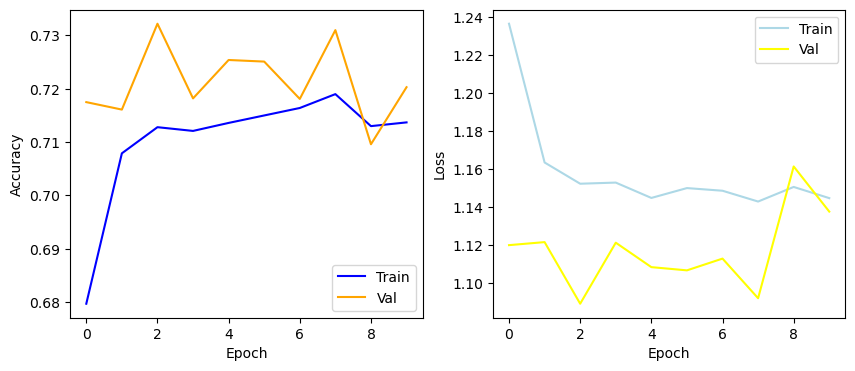

In [84]:
show_training_metrics(logs)

### Deploy model for inference

In [94]:
from sagemaker.utils import name_from_base

inference_instance_type = "ml.g4dn.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"{training_job_name}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = tf_ic_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2024-03-12-20-29-13-197
INFO:sagemaker:Creating endpoint-config with name isic-resnet-v2-finetune--2024-03-12-20-29-13-197
INFO:sagemaker:Creating endpoint with name isic-resnet-v2-finetune--2024-03-12-20-29-13-197


----------!

# 

In [96]:
s3 = boto3.resource('s3', region_name=aws_region)
bucket = s3.Bucket('isicbucket')

In [115]:
from PIL import Image
from io import BytesIO
import numpy as np

def read_image_from_s3_as_bytes(key, bucket):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    buffer = BytesIO()
    im.save(buffer, format='JPEG')
    byte_im = buffer.getvalue()

    return byte_im

### Show confusion matrix

In [98]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix, classification_report

In [99]:
def plot_heat_map(confusion_mat):
    """Plot a confusion matrix as a seaborn heatmap."""
    
    heat_map = heatmap(confusion_mat, 
                       annot=True, 
                       fmt='.3g', 
                       cmap='Blues',
                       #xticklabels=CLASS_NAMES_LONG, 
                       #yticklabels=CLASS_NAMES_LONG, 
                       cbar=False)
    heat_map.set(xlabel='Predicted Label', ylabel='True Label')


In [114]:
img = read_image_from_s3_as_bytes("preprocessed/train_preprocess_ps_224_new/actinic keratoses/ISIC_0024468.jpg", bucket)
query_response = finetuned_predictor.predict(
    img, {"ContentType": "application/x-image", "Accept": "application/json;verbose"}
)
model_predictions = json.loads(query_response)
predicted_label = model_predictions["predicted_label"]
model_predictions

{'probabilities': [0.170433238,
  0.638382494,
  0.00569340121,
  0.02269415,
  0.00716251461,
  0.00309727341,
  0.138120577,
  0.0119343018,
  0.00248200842],
 'labels': ['actinic keratoses',
  'basal cell carcinoma',
  'dermatofibroma',
  'keratosis',
  'melanoma',
  'nevus',
  'squamous cell carcinoma',
  'unknown',
  'vascular skin'],
 'predicted_label': 'basal cell carcinoma'}

## Clean up endpoint

In [117]:
finetuned_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: isic-resnet-v2-finetune--2024-03-12-20-29-13-197
INFO:sagemaker:Deleting endpoint with name: isic-resnet-v2-finetune--2024-03-12-20-29-13-197
